In this post I am implementing Graph Convolutional Layer 

# Basic Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch_geometric.datasets import Planetoid
import torch.optim as optim
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Importing Planetoid dataset - Cora

In [2]:
dataset = Planetoid(root='data/Planetoid', name='Cora')


In [3]:
def visualize(h, color):
    # Perform t-SNE dimensionality reduction
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    # Create a scatter plot of the t-SNE embeddings
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Visulization of the dataset

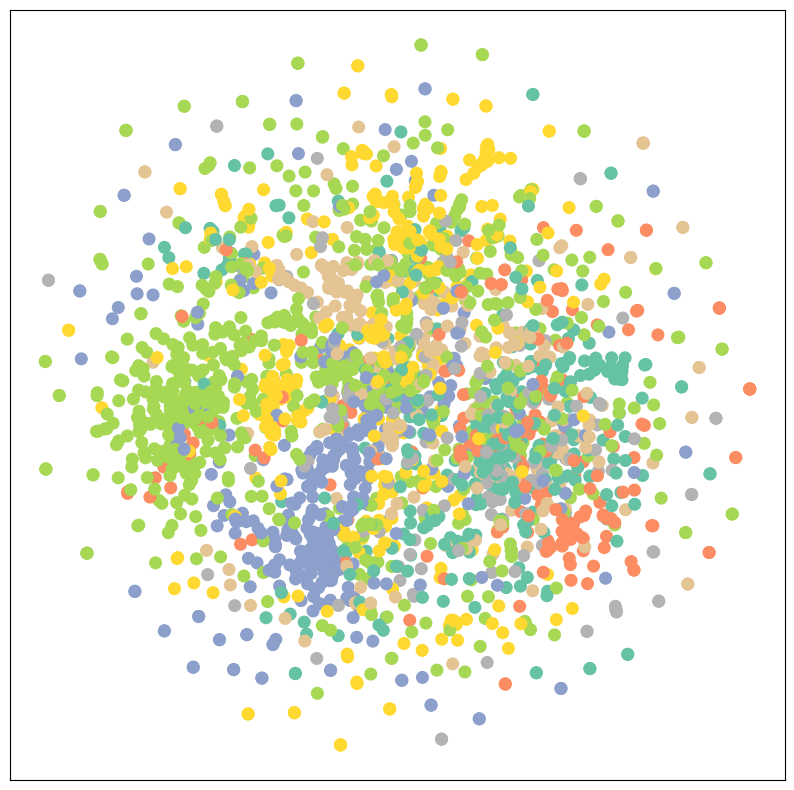

In [4]:
visualize(dataset[0].x, dataset[0].y)

In [5]:
# convert pytorch tensor to networkx graph
def to_networkx(data):
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    G.add_edges_from(data.edge_index.t().tolist())
    return G

In [6]:
G = to_networkx(dataset[0])


# Creating the Adjacency Matrix

In [7]:
# Adjacency matrix
A = nx.adjacency_matrix(G).todense()
A = torch.tensor(A, dtype=torch.float)

# Creating a GCN layer

The GCN layer is defined as follows:

${H}^{(l+1)} = \sigma \left( \mathbf{D}^{-\frac{1}{2}} {\mathbf{\hat{A}}}
 \mathbf{D}^{-\frac{1}{2}} \mathbf{H}^{(l)} \mathbf{W}^{(l)} \right)$

where $\mathbf{H}^{(l)}$ is the $l^{th}$ layer of the GCN, $\mathbf{A}$ is the adjacency matrix, ${\mathbf{\hat{A}}}$ is the adjacency matrix with self-connections added, $\mathbf{D}$ is the degree matrix, and $\mathbf{W}^{(l)}$ is the weight matrix for the $l^{th}$ layer.

In [8]:
class GCN_Layer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCN_Layer, self).__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
        
    def gcn_layer(self, A, D):
        A_hat1 = A + torch.eye(A.shape[0], device=A.device)
        return torch.matmul(torch.matmul(D, A_hat1), D)
    
    def forward(self, A, X):
        D = torch.diag(torch.sum(A+torch.eye(A.shape[0], device=A.device), dim=0) ** (-0.5))
        A_hat = self.gcn_layer(A, D)
        return F.relu(torch.matmul(A_hat, self.linear(X)))


# Creating the model

The model consists of two GCN layers and a linear layer for the output. We have used ReLU as the activation function.

In [9]:
class GNNModel(nn.Module):
    def __init__(self, in_features, out_features, classes):
        super(GNNModel, self).__init__()
        self.layer1 = GCN_Layer(in_features, out_features)
        self.layer2 = GCN_Layer(out_features, out_features)
        self.linear = nn.Linear(out_features, classes)
        
    def forward(self, A, X):
        H = self.layer1(A, X)
        H = nn.ReLU()(H)
        H = self.layer2(A, H)
        H = nn.ReLU()(H)
        H = self.linear(H)
        return nn.Softmax(dim=1)(H)

# Training the model

In [10]:
X = dataset[0].x
y = dataset[0].y
in_features = X.shape[1]  # Number of input features
hidden_dim = 64  # Number of hidden features
classes = 7  # Number of classes
gcn_layer = GNNModel(in_features, hidden_dim, classes)
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification
optimizer = torch.optim.Adam(gcn_layer.parameters(), lr=0.01)
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    output = gcn_layer(A, X)

    # Compute the loss
    loss = criterion(output, y)  # Assume y contains the ground truth class labels
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Compute the accuracy
    predicted_labels = output.argmax(dim=1)
    accuracy = (predicted_labels == y).float().mean()

    # Print the loss and accuracy for monitoring
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')


Epoch [1/100], Loss: 1.9459, Accuracy: 0.0702
Epoch [2/100], Loss: 1.9383, Accuracy: 0.3316
Epoch [3/100], Loss: 1.9238, Accuracy: 0.3024
Epoch [4/100], Loss: 1.8966, Accuracy: 0.3021
Epoch [5/100], Loss: 1.8567, Accuracy: 0.3021
Epoch [6/100], Loss: 1.8174, Accuracy: 0.3021
Epoch [7/100], Loss: 1.7879, Accuracy: 0.3024
Epoch [8/100], Loss: 1.7328, Accuracy: 0.4346
Epoch [9/100], Loss: 1.6781, Accuracy: 0.5835
Epoch [10/100], Loss: 1.6422, Accuracy: 0.5735
Epoch [11/100], Loss: 1.5881, Accuracy: 0.6141
Epoch [12/100], Loss: 1.5457, Accuracy: 0.6647
Epoch [13/100], Loss: 1.5212, Accuracy: 0.6747
Epoch [14/100], Loss: 1.5006, Accuracy: 0.6765
Epoch [15/100], Loss: 1.4805, Accuracy: 0.6839
Epoch [16/100], Loss: 1.4607, Accuracy: 0.6994
Epoch [17/100], Loss: 1.4392, Accuracy: 0.7448
Epoch [18/100], Loss: 1.4178, Accuracy: 0.7744
Epoch [19/100], Loss: 1.4071, Accuracy: 0.7740
Epoch [20/100], Loss: 1.4041, Accuracy: 0.7707
Epoch [21/100], Loss: 1.3950, Accuracy: 0.7758
Epoch [22/100], Loss: 

In [11]:
output = gcn_layer(A, X)
y_pred = output.argmax(dim=1)
y = dataset[0].y
print(f'Accuracy of GCN model: {float(((y == y_pred).sum()) / len(y))*100}')

Accuracy of GCN model: 96.27031087875366
